# Assignment 2, Task 2 - Nuclear reactors data classification

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


In [0]:
sns.set_style("darkgrid")
sns.set(font_scale=1.3)

## Setup Spark environment
Note: the code in this section has been adapted from DM&V Practical 4.

In [0]:
import os

In [0]:
# set environmental variables
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-2.4.5-bin-hadoop2.7"

In [184]:
# install java
!apt-get install -y openjdk-8-jdk-headless -qq > /dev/null      #install openjdk
!java -version       #check java version

openjdk version "11.0.6" 2020-01-14
OpenJDK Runtime Environment (build 11.0.6+10-post-Ubuntu-1ubuntu118.04.1)
OpenJDK 64-Bit Server VM (build 11.0.6+10-post-Ubuntu-1ubuntu118.04.1, mixed mode, sharing)


In [0]:
!wget -q https://www-us.apache.org/dist/spark/spark-2.4.5/spark-2.4.5-bin-hadoop2.7.tgz
!tar xf spark-2.4.5-bin-hadoop2.7.tgz
!pip install -q findspark

In [0]:
import findspark
findspark.init()

In [0]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local[*]").appName("Learning_Spark").getOrCreate()

## Load data

In [188]:
# upload file
from google.colab import files
files.upload()

Saving data.csv to data (1).csv


{'data.csv': b'\xef\xbb\xbfStatus,Power_range_sensor_1,Power_range_sensor_2,Power_range_sensor_3 ,Power_range_sensor_4,Pressure _sensor_1,Pressure _sensor_2,Pressure _sensor_3,Pressure _sensor_4,Vibration_sensor_1,Vibration_sensor_2,Vibration_sensor_3,Vibration_sensor_4\r\nNormal,4.5044,0.7443,6.34,1.9052,29.5315,0.8647,2.2044,6.048,14.4659,21.648,15.3429,1.2186\r\nNormal,4.4284,0.9073,5.6433,1.6232,27.5032,1.4704,1.9929,5.9856,20.8356,0.0646,14.8813,7.3483\r\nNormal,4.5291,1.0199,6.113,1.0565,26.4271,1.9247,1.942,6.7162,5.3358,11.0779,25.0914,9.2408\r\nNormal,5.1727,1.0007,7.8589,0.2765,25.1576,2.609,2.9234,6.7485,1.9017,1.8463,28.664,4.0157\r\nNormal,5.2258,0.6125,7.9504,0.1547,24.0765,3.2113,4.4563,5.8411,0.5077,9.37,34.8122,13.4966\r\nNormal,4.8834,0.5786,5.6021,0.5942,21.0365,2.6275,4.3996,5.3487,3.6465,9.3793,36.2431,11.124\r\nNormal,5.7422,0.8862,5.1013,0.9402,15.5171,2.92,2.7061,5.0366,9.1854,9.1116,27.3162,2.8526\r\nNormal,6.5076,0.5438,7.153,0.6711,11.1481,4.2967,3.5731,4.612

In [189]:
# load the data file using pandas - better for generating descriptions of the data
df = pd.read_csv('data.csv')
df.head()

,Status,Power_range_sensor_1,Power_range_sensor_2,Power_range_sensor_3,Power_range_sensor_4,Pressure _sensor_1,Pressure _sensor_2,Pressure _sensor_3,Pressure _sensor_4,Vibration_sensor_1,Vibration_sensor_2,Vibration_sensor_3,Vibration_sensor_4
0,Normal,4.5044,0.7443,6.3400,1.9052,29.5315,0.8647,2.2044,6.0480,14.4659,21.6480,15.3429,1.2186
1,Normal,4.4284,0.9073,5.6433,1.6232,27.5032,1.4704,1.9929,5.9856,20.8356,0.0646,14.8813,7.3483
2,Normal,4.5291,1.0199,6.1130,1.0565,26.4271,1.9247,1.9420,6.7162,5.3358,11.0779,25.0914,9.2408
3,Normal,5.1727,1.0007,7.8589,0.2765,25.1576,2.6090,2.9234,6.7485,1.9017,1.8463,28.6640,4.0157
4,Normal,5.2258,0.6125,7.9504,0.1547,24.0765,3.2113,4.4563,5.8411,0.5077,9.3700,34.8122,13.4966


In [190]:
feature_names = list(df.columns[1:])
feature_names

['Power_range_sensor_1',
 'Power_range_sensor_2',
 'Power_range_sensor_3 ',
 'Power_range_sensor_4',
 'Pressure _sensor_1',
 'Pressure _sensor_2',
 'Pressure _sensor_3',
 'Pressure _sensor_4',
 'Vibration_sensor_1',
 'Vibration_sensor_2',
 'Vibration_sensor_3',
 'Vibration_sensor_4']

In [191]:
df[feature_names[:6]].describe().round(3)

,Power_range_sensor_1,Power_range_sensor_2,Power_range_sensor_3,Power_range_sensor_4,Pressure _sensor_1,Pressure _sensor_2
count,996.000,996.000,996.000,996.000,996.000,996.000
mean,5.000,6.379,9.228,7.355,14.199,3.078
std,2.765,2.313,2.532,4.355,11.680,2.126
min,0.008,0.040,2.584,0.062,0.025,0.008
25%,2.892,4.932,7.511,3.438,5.015,1.416
50%,4.881,6.470,9.348,7.072,11.717,2.672
75%,6.795,8.105,11.047,10.917,20.280,4.502
max,12.130,11.928,15.760,17.236,67.979,10.243


In [192]:
df[feature_names[6:]].describe().round(3)

,Pressure _sensor_3,Pressure _sensor_4,Vibration_sensor_1,Vibration_sensor_2,Vibration_sensor_3,Vibration_sensor_4
count,996.000,996.000,996.000,996.000,996.000,996.000
mean,5.749,4.997,8.165,10.002,15.188,9.934
std,2.526,4.165,6.173,7.336,12.160,7.282
min,0.001,0.006,0.000,0.018,0.065,0.009
25%,4.023,1.582,3.190,4.004,5.509,3.843
50%,5.741,3.859,6.753,8.793,12.186,8.853
75%,7.504,7.600,11.253,14.684,21.835,14.357
max,12.648,16.556,36.186,34.868,53.238,43.231


In [193]:
# check for missing values
df.isna().sum()

Status                   0
Power_range_sensor_1     0
Power_range_sensor_2     0
Power_range_sensor_3     0
Power_range_sensor_4     0
Pressure _sensor_1       0
Pressure _sensor_2       0
Pressure _sensor_3       0
Pressure _sensor_4       0
Vibration_sensor_1       0
Vibration_sensor_2       0
Vibration_sensor_3       0
Vibration_sensor_4       0
dtype: int64

In [194]:
df['Status'].value_counts()

Normal      498
Abnormal    498
Name: Status, dtype: int64

## Data visualisation

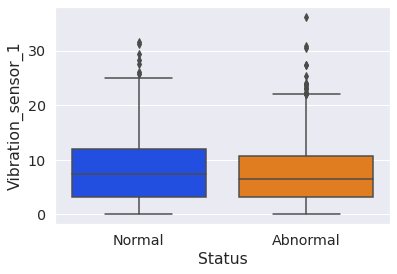

In [195]:
sns.boxplot(data=df, x='Status', y='Vibration_sensor_1', palette='bright')

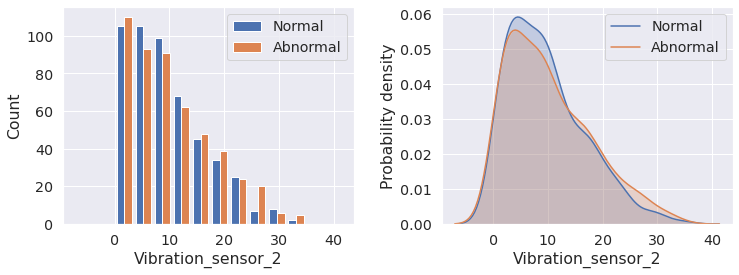

In [196]:
plot_var = 'Vibration_sensor_2'
fig, axes = plt.subplots(1, 2, figsize=(12,4), sharex='all')

class_labels = df['Status'].unique()
hist_data = [df[plot_var][df['Status']==class_label] for class_label in class_labels]

axes[0].hist(hist_data, label=class_labels)
axes[0].legend()
axes[0].set_ylabel('Count')

for i, class_label in enumerate(class_labels):
    sns.kdeplot(hist_data[i], ax=axes[1], label=class_label, shade=True)
axes[1].set_ylabel('Probability density')

for ax in axes:
  ax.set_xlabel(plot_var)

fig.subplots_adjust(wspace=0.3)

## Data preparation

In [197]:
# switch to spark
data = spark.createDataFrame(df)
data.show(10)

+------+--------------------+--------------------+---------------------+--------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+
|Status|Power_range_sensor_1|Power_range_sensor_2|Power_range_sensor_3 |Power_range_sensor_4|Pressure _sensor_1|Pressure _sensor_2|Pressure _sensor_3|Pressure _sensor_4|Vibration_sensor_1|Vibration_sensor_2|Vibration_sensor_3|Vibration_sensor_4|
+------+--------------------+--------------------+---------------------+--------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+
|Normal|              4.5044|              0.7443|                 6.34|              1.9052|           29.5315|            0.8647|            2.2044| 6.047999999999999|           14.4659|21.648000000000003|           15.3429|            1.2186|
|Normal|        

In [0]:
# add a new column - transform 'Status' to numerical class label
data_prep = data.withColumn('label', (data.Status=='Abnormal').astype("float"))

In [199]:
# combine features for classification
from pyspark.ml.feature import VectorAssembler

data_prep = VectorAssembler(inputCols=feature_names, outputCol="features").transform(data_prep)
data_prep.printSchema()

root
 |-- Status: string (nullable = true)
 |-- Power_range_sensor_1: double (nullable = true)
 |-- Power_range_sensor_2: double (nullable = true)
 |-- Power_range_sensor_3 : double (nullable = true)
 |-- Power_range_sensor_4: double (nullable = true)
 |-- Pressure _sensor_1: double (nullable = true)
 |-- Pressure _sensor_2: double (nullable = true)
 |-- Pressure _sensor_3: double (nullable = true)
 |-- Pressure _sensor_4: double (nullable = true)
 |-- Vibration_sensor_1: double (nullable = true)
 |-- Vibration_sensor_2: double (nullable = true)
 |-- Vibration_sensor_3: double (nullable = true)
 |-- Vibration_sensor_4: double (nullable = true)
 |-- label: float (nullable = true)
 |-- features: vector (nullable = true)



In [200]:
# split data to train and test sets
data_train, data_test = data_prep.randomSplit([0.75, 0.25])

for n, d in (('Train', data_train), ('Test', data_test)):
    print(f"{n} size: {d.count()} ({100*(d.count()/data_prep.count()):.1f}%)")

Train size: 746 (74.9%)
Test size: 250 (25.1%)


## Data classification
### Model definition and fitting

In [0]:
from pyspark.ml.classification import LogisticRegression

In [0]:
# define classifier models
models = {'Logistic Regression': LogisticRegression(),
          'Gradient Boosted Tree': LogisticRegression()}

# train the models and predict classes of the test set
predictions = {model_name: model.fit(data_train).evaluate(data_test) for model_name, model in models.items()}


### Model evaluation

In [0]:
from pyspark.mllib.evaluation import MulticlassMetrics

In [0]:
indices = [f'{pa} {pn}' for pa in ['Actual', 'Predicted'] for pn in ['Positive', 'Negative']]

# confusion matrix calculation
# based on: https://stackoverflow.com/a/58405759/13230295

def conf_matrix(model):
    for model_name, pred in predictions.items():
        metrics = MulticlassMetrics(pred.predictions.select(['label', 'prediction']).rdd.map(tuple))
        return pd.DataFrame(metrics.confusionMatrix().toArray(), index=indices[:2], columns=indices[2:])

In [268]:
conf_matrix(predictions['Logistic Regression'])

,Predicted Positive,Predicted Negative
Actual Positive,77.0,41.0
Actual Negative,32.0,100.0


In [270]:
conf_matrix(predictions['Gradient Boosted Tree'])

,Predicted Positive,Predicted Negative
Actual Positive,77.0,41.0
Actual Negative,32.0,100.0


In [278]:
# summary and comparison of performance scores of both models

pd.DataFrame([{'Accuracy': pred.accuracy,
               'Precision': pred.weightedPrecision,
               'Recall': pred.weightedRecall,
               'F1 score': pred.weightedFMeasure(),
               'ROC AUC': pred.areaUnderROC} for pred in predictions.values()],
             index=predictions.keys()).round(3)

,Accuracy,Precision,Recall,F1 score,ROC AUC
Logistic Regression,0.708,0.712,0.708,0.709,0.783
Gradient Boosted Tree,0.708,0.712,0.708,0.709,0.783


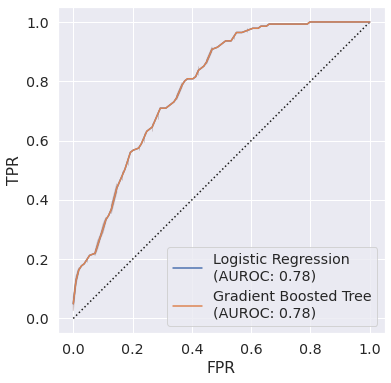

In [275]:
# ROC curves for both models

fig, ax = plt.subplots(figsize=(6, 6))
ax.set_aspect('equal')
ax.plot([0, 1], [0, 1], 'k:')

for model_name, pred in predictions.items():
    sns.lineplot(ax=ax, data=pred.roc.toPandas(), x='FPR', y='TPR',
                 label=f"{model_name}\n(ROC AUC: {pred.areaUnderROC:.2f})")